In [1]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [2]:
%load_ext blackcellmagic

In [3]:
from scr.preprocess.data_process import TaskProcess

In [7]:
"""Pre-processing the dataset"""

from __future__ import annotations

from collections import defaultdict

import os
from glob import glob
import tables
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset, DataLoader

from scr.utils import pickle_save, pickle_load, replace_ext, read_std_csv
from scr.params.sys import RAND_SEED
from scr.params.emb import TRANSFORMER_INFO, CARP_INFO, MAX_SEQ_LEN
from scr.vis.dataset_vis import DatasetECDF
from scr.preprocess.seq_loader import SeqLoader
from scr.encoding.encoding_classes import (
    AbstractEncoder,
    ESMEncoder,
    CARPEncoder,
    OnehotEncoder,
)


def get_mut_name(mut_seq: str, parent_seq: str) -> str:
    """
    A function for returning the mutant name

    Args:
    - mut_seq: str, the full mutant sequence
    - parent_seq: str, the full parent sequence

    Returns:
    - str, parent, indel, or mutant name in the format of
        ParentAAMutLocMutAA:ParentAAMutLocMutAA:..., ie. W39W:D40G:G41C:V54Q
    """

    mut_list = []
    if parent_seq == mut_seq:
        return "parent"
    elif len(parent_seq) == len(mut_seq):
        for i, (p, m) in enumerate(zip(list(parent_seq), list(mut_seq))):
            if p != m:
                mut_list.append(f"{p}{i+1}{m}")
        return ":".join(mut_list)
    else:
        return "indel"


def get_parent_fit(df: pd.DataFrame) -> float:
    """Return the parent fitness value"""

    assert "target" in df.columns, "target is not a column in the dataframe"
    assert "sequence" in df.columns, "sequence is not a column in the dataframe"

    return df["target"][df["mut_name"] == "parent"].values.mean()


class AddMutInfo:
    """A class for appending mutation info for mainly protein engineering tasks"""

    def __init__(self, parent_seq_path: str, csv_path: str):

        """
        Args:
        - parent_seq_path: str, path for the parent sequence
        - csv_path: str, path for the fitness csv file
        """

        # Load the parent sequence from the fasta file
        self._parent_seq = SeqLoader(fasta_loc=parent_seq_path).seq

        # load the dataframe
        self._init_df = read_std_csv(csv_path)
        self._df = self._init_df.copy()

        # add a column with the mutant names
        self._df["mut_name"] = self._init_df["sequence"].apply(
            get_mut_name, parent_seq=self._parent_seq
        )
        # add a column with the number of mutations
        self._df["mut_numb"] = (
            self._df["mut_name"].str.split(":").map(len, na_action="ignore")
        )

        # check number of parents
        parent_idx = self._df[self._df["mut_name"] == "parent"].index.tolist()
        numb_parent = len(parent_idx)

        if numb_parent < 1:
            print("no parent")
        elif numb_parent > 1:
            print(f"{numb_parent} parents observed")

        # change the mut_numb of parent to 0
        self._df.loc[parent_idx, "mut_numb"] = 0

        # get the pickle file path
        self._pkl_path = replace_ext(input_path=csv_path, ext=".pkl")

        pickle_save(what2save=self._df, where2save=self._pkl_path)

    @property
    def parent_seq(self) -> str:
        """Return the parent sequence"""
        return self._parent_seq

    @property
    def pkl_path(self) -> str:
        """Return the pkl file path for the processed dataframe"""
        return self._pkl_path

    @property
    def df(self) -> pd.DataFrame:
        """Return the processed dataframe"""
        return self._df

    @property
    def parent_fit(self) -> float:
        """Return the parent fitness value"""
        return get_parent_fit(self._df)


def std_split_ssdf(
    ssdf_path: str = "data/structure/secondary_structure/tape_ss3.csv",
    split_test: bool = True,
) -> None:
    """
    A function that standardize secondary structure dataset
    to set up as columns as sequence, target, set, validation
    where set is train or test and add validation as true
    """
    folder_path = os.path.dirname(ssdf_path)

    df = pd.read_csv(ssdf_path)

    # add validation column
    df["validation"] = df["split"].apply(lambda x: True if x == "valid" else "")
    # now replace valid to train
    df = df.replace("valid", "train")
    # rename all columns
    df.columns = ["sequence", "target", "set", "validation"]

    if split_test:
        # get all kinds of test sets
        ss_tests = set(df["set"].unique()) - set(["train"])

        for ss_test in ss_tests:
            df.loc[~df["set"].isin(set(ss_tests) - set([ss_test]))].replace(
                ss_test, "test"
            ).to_csv(os.path.join(folder_path, ss_test + ".csv"), index=False)

    else:
        df.to_csv(f"{os.path.splitext(ssdf_path)[0]}_processed.csv", index=False)


def split_df_sets(df: pd.DataFrame) -> dict[pd.DataFrame]:
    """
    Return split dataframe for training, validation, and testing

    Args:
    - df: pd.DataFrame, input dataframe

    Returns:
    - a dict of dataframes for train, val, test (or ss3 tasks)
    """

    assert "set" in df.columns, f"set is not a column in the dataframe"
    assert "validation" in df.columns, f"validation is not a column in the dataframe"

    # init split df dict output
    df_dict = {}

    df_dict["train"] = df.loc[
        (df["set"] == "train") & (df["validation"] != True)
    ].reset_index(drop=True)
    df_dict["val"] = df.loc[
        (df["set"] == "train") & (df["validation"] == True)
    ].reset_index(drop=True)

    test_tasks = set(df["set"].unique()) - set(["train"])

    for test_task in test_tasks:
        df_dict[test_task] = df.loc[(df["set"] == test_task)].reset_index(drop=True)

    return df_dict


class DatasetInfo:
    """
    A class returns the information of a dataset
    """

    def __init__(self, dataset_path: str) -> None:
        """
        Args:
        - dataset_path: str, the path for the csv
        """

        self._df = read_std_csv(dataset_path)
        self._df_dict = split_df_sets(self._df)

    def get_model_type(self) -> str:
        # pick linear regression if y numerical
        if self._df.target.dtype.kind in "iufc":
            return "LinearRegression"
        else:
            # ss3
            if "[" in self._df.target[0]:
                return "MultiLabelMultiClass"
            # annotation
            else:
                return "LinearClassifier"

    def get_numb_class(self) -> int:
        """
        A function to get number of class
        """
        # annotation class number
        if self.model_type == "LinearClassifier":
            return self._df.target.nunique()
        # ss3 or ss8 secondary structure states plus padding
        elif self.model_type == "MultiLabelMultiClass":
            return len(np.unique(np.array(self._df["target"][0][1:-1].split(", "))))
        else:
            return np.nan

    @property
    def df_dict(self) -> dict:
        """Return split dataset based on train, val, test"""
        return self._df_dict

    @property
    def train_numb(self) -> int:
        """Number of train data"""
        return len(self._df_dict["train"])

    @property
    def val_numb(self) -> int:
        """Number of val data"""
        return len(self._df_dict["val"])

    @property
    def test_numb(self) -> int:
        """Number of test data"""
        return len(self._df_dict["test"])

    @property
    def model_type(self) -> str:
        """Return the pytorch model type"""
        return self.get_model_type()

    @property
    def numb_class(self) -> int:
        """Return number of classes for classification"""
        return self.get_numb_class()

    @property
    def subset_list(self) -> list[str]:
        """Return a list of subset"""
        subset_list = list(self._df["set"].unique())
        subset_list.insert(1, "val")
        return subset_list


class TaskProcess:
    """A class for handling different downstream tasks"""

    def __init__(
        self,
        data_folder: str = "data/",
        forceregen: bool = False,
    ):
        """
        Args:
        - data_folder: str, a folder path with all the tasks as subfolders where
            all the subfolders have datasets as the subsubfolders, ie

            {data_folder}/
                proeng/
                    aav/
                        one_vs_many.csv
                        two_vs_many.csv
                        P03135.fasta
                    thermo/
                        mixed.csv
        - forceregen: bool = False, if force regenerate the pkl files
        """

        self._data_folder = os.path.normpath(data_folder) + "/"
        self._forceregen = forceregen

        # sumamarize all files i nthe data folder
        self._sum_file_df = self.sum_files()

    def sum_files(self) -> pd.DataFrame:
        """
        Summarize all files in the data folder

        Returns:
        - A dataframe with "task", "dataset", "split",
            "csv_path", "fasta_path", "pkl_path" as columns, ie.
            (proeng, gb1, low_vs_high, data/proeng/gb1/low_vs_high.csv,
            data/proeng/gb1/5LDE_1.fasta)
            note that csv_path is the list of lmdb files for the structure task
        """
        dataset_folders = glob(f"{self._data_folder}*/*")
        # need a list of tuples in the order of:
        # (task, dataset, split, csv_path, fasta_path)
        list_for_df = []
        for dataset_folder in dataset_folders:
            _, task, dataset = dataset_folder.split("/")

            csv_paths = glob(f"{dataset_folder}/*.csv")

            if task == "structure":
                csv_paths = set(csv_paths) - set(
                    glob(f"{dataset_folder}/tape_ss3*.csv")
                )

            fasta_paths = glob(f"{dataset_folder}/*.fasta")
            pkl_paths = glob(f"{dataset_folder}/*.pkl")

            assert len(csv_paths) >= 1, "Less than one csv"
            assert len(fasta_paths) <= 1, "More than one fasta"

            for csv_path in csv_paths:

                # if numerical target
                ds_info = DatasetInfo(dataset_path=csv_path)
                if ds_info.model_type == "LinearRegression":
                    # plot ecdf for each csv file
                    DatasetECDF(dataset_path=csv_path)

                # if parent seq fasta exists
                if len(fasta_paths) == 1:
                    fasta_path = fasta_paths[0]

                    # if no existing pkl file, generate and save
                    if len(pkl_paths) == 0 or self._forceregen:
                        print(f"Adding mutation info to {csv_path}...")
                        addmutinfo_class = AddMutInfo(
                            parent_seq_path=fasta_path, csv_path=csv_path
                        )
                        pkl_path = addmutinfo_class.pkl_path
                        parent_fit = addmutinfo_class.parent_fit

                    # pkl file exits
                    else:
                        pkl_path = replace_ext(input_path=csv_path, ext=".pkl")
                        parent_fit = get_parent_fit(pickle_load(pkl_path))
                # no parent fasta no pkl file
                else:
                    fasta_path = ""
                    pkl_path = ""
                    parent_fit = np.nan

                df_dict = split_df_sets(read_std_csv(csv_path))

                list_for_df.append(
                    tuple(
                        [
                            task,
                            dataset,
                            os.path.basename(os.path.splitext(csv_path)[0]),
                            ds_info.train_numb,
                            ds_info.val_numb,
                            ds_info.test_numb,
                            ds_info.model_type,
                            ds_info.numb_class,
                            parent_fit,
                            csv_path,
                            fasta_path,
                            pkl_path,
                        ]
                    )
                )

        return pd.DataFrame(
            list_for_df,
            columns=[
                "task",
                "dataset",
                "split",
                "train_numb",
                "val_numb",
                "test_numb",
                "model_type",
                "numb_class",
                "parent_fit",
                "csv_path",
                "fasta_path",
                "pkl_path",
            ],
        )

    @property
    def sum_file_df(self) -> pd.DataFrame:
        """A summary table for all files in the data folder"""
        return self._sum_file_df


class ProtranDataset(Dataset):

    """A dataset class for processing protein transfer data"""

    def __init__(
        self,
        dataset_path: str,
        subset: str,
        encoder_name: str,
        reset_param: bool = False,
        resample_param: bool = False,
        embed_batch_size: int = 0,
        flatten_emb: bool | str = False,
        embed_folder: str = None,
        embed_layer: int | None = None,
        seq_start_idx: bool | int = False,
        seq_end_idx: bool | int = False,
        if_encode_all: bool = True,
        **encoder_params,
    ):

        """
        Args:
        - dataset_path: str, full path to the dataset, in pkl or panda readable format, ie
            "data/proeng/gb1/low_vs_high.csv"
            columns include: sequence, target, set, validation,
            mut_name (optional), mut_numb (optional)
        - subset: str, train, val, test
        - encoder_name: str, the name of the encoder
        - reset_param: bool = False, if update the full model to xavier_uniform_
        - resample_param: bool = False, if update the full model to xavier_normal_
        - embed_batch_size: int, set to 0 to encode all in a single batch
        - flatten_emb: bool or str, if and how (one of ["max", "mean"]) to flatten the embedding
        - embed_folder: str = None, path to presaved embedding folder, ie
            "embeddings/proeng/gb1/low_vs_high"
            for which then can add the subset to be, ie
            "embeddings/proeng/gb1/low_vs_high/esm1_t6_43M_UR50S/mean/test/embedding.h5"
        - seq_start_idx: bool | int = False, the index for the start of the sequence
        - seq_end_idx: bool | int = False, the index for the end of the sequence
        - if_encode_all: bool = True, if encode full dataset all layers on the fly
        - encoder_params: kwarg, additional parameters for encoding
        """

        # with additional info mut_name, mut_numb
        if os.path.splitext(dataset_path)[-1] in [".pkl", ".PKL", ""]:
            self._df = pickle_load(dataset_path)
            self._add_mut_info = True
        # without such info
        else:
            self._df = read_std_csv(dataset_path)
            self._ds_info = DatasetInfo(dataset_path)
            self._model_type = self._ds_info.model_type
            self._numb_class = self._ds_info.numb_class

            self._add_mut_info = False

        self._df_dict = split_df_sets(self._df)

        assert subset in list(
            self._df_dict.keys()
        ), "split can only be 'train', 'val', 'test' or 'cb513', 'ts115', 'casp12'"
        self._subset = subset

        self._subdf_len = len(self._df_dict[self._subset])

        # not specified seq start will be from 0
        if seq_start_idx == False:
            self._seq_start_idx = 0
        else:
            self._seq_start_idx = int(seq_start_idx)
        # not specified seq end will be the full sequence length
        if seq_end_idx == False:
            self._seq_end_idx = -1
            self._max_seq_len = self._df.sequence.str.len().max()
        else:
            self._seq_end_idx = int(seq_end_idx)
            self._max_seq_len = self._seq_end_idx - self._seq_start_idx

        # get unencoded string of input sequence
        # will need to convert data type
        self.sequence = self._get_column_value("sequence")

        self.if_encode_all = if_encode_all
        self._embed_folder = embed_folder

        self._encoder_name = encoder_name
        self._flatten_emb = flatten_emb

        # get the encoder class
        if self._encoder_name in TRANSFORMER_INFO.keys():
            encoder_class = ESMEncoder
        elif self._encoder_name in CARP_INFO.keys():
            encoder_class = CARPEncoder
        else:
            self._encoder_name == "onehot"
            encoder_class = OnehotEncoder
            encoder_params["max_seq_len"] = self._max_seq_len

        # get the encoder
        self._encoder = encoder_class(
            encoder_name=self._encoder_name,
            reset_param=reset_param,
            resample_param=resample_param,
            **encoder_params,
        )
        self._total_emb_layer = self._encoder.total_emb_layer
        self._embed_layer = embed_layer

        # encode all and load in memory
        if self.if_encode_all or (
            self._embed_folder is None and self._embed_layer is None
        ):
            print("Encoding all...")
            # encode the sequences without the mut_name
            # init an empty dict with empty list to append emb
            encoded_dict = defaultdict(list)

            # use the encoder generator for batch emb
            # assume no labels included
            for encoded_batch_dict in self._encoder.encode(
                mut_seqs=self.sequence,
                batch_size=embed_batch_size,
                flatten_emb=self._flatten_emb,
            ):

                for layer, emb in encoded_batch_dict.items():
                    encoded_dict[layer].append(emb)

            # assign each layer as its own variable
            for layer, emb in encoded_dict.items():
                setattr(self, "layer" + str(layer), np.vstack(emb))

        # load full one layer embedding
        if self._embed_folder is not None and self._embed_layer is not None:
            print(f"Load {self._embed_layer} from {self._embed_folder}...")

            emb_table = tables.open_file(
                os.path.join(
                    self._embed_folder,
                    self._encoder_name,
                    self._flatten_emb,
                    self._subset,
                    "embedding.h5",
                )
            )

            emb_table.flush()

            setattr(
                self,
                "layer" + str(self._embed_layer),
                getattr(emb_table.root, "layer" + str(self._embed_layer))[:],
            )

            emb_table.close()
        # get and format the fitness or secondary structure values
        # can be numbers or string
        # will need to convert data type
        # make 1D tensor 2D
        self.y = np.expand_dims(self._get_column_value("target"), 1)

        # add mut_name and mut_numb for relevant proeng datasets
        if self._add_mut_info:
            self.mut_name = self._get_column_value("mut_name")
            self.mut_numb = self._get_column_value("mut_numb")
        else:
            self.mut_name = [""] * self._subdf_len
            self.mut_numb = [np.nan] * self._subdf_len

    def __len__(self):
        """Return the length of the selected subset of the dataframe"""
        return self._subdf_len

    def __getitem__(self, idx: int):

        """
        Return the item in the order of
        target (y), sequence, mut_name (optional), mut_numb (optional),
        embedding per layer upto the max number of layer for the encoder

        Args:
        - idx: int
        """
        if self.if_encode_all and self._embed_folder is None:

            return (
                self.y[idx],
                self.sequence[idx],
                self.mut_name[idx],
                self.mut_numb[idx],
                *(
                    getattr(self, "layer" + str(layer))[idx]
                    for layer in range(self._total_emb_layer)
                ),
            )
        elif self._embed_folder is not None:
            # load the .h5 file with the embeddings
            """
            gb1_emb = tables.open_file("embeddings/proeng/gb1/low_vs_high/esm1_t6_43M_UR50S/mean/test/embedding.h5")
            gb1_emb.flush()
            gb1_emb.root.layer0[0:5]
            """
            # return all
            if self._embed_layer is None:

                emb_table = tables.open_file(
                    os.path.join(
                        self._embed_folder,
                        self._encoder_name,
                        self._flatten_emb,
                        self._subset,
                        "embedding.h5",
                    )
                )

                emb_table.flush()

                layer_embs = [
                    getattr(emb_table.root, "layer" + str(layer))[idx]
                    for layer in range(self._total_emb_layer)
                ]

                emb_table.close()

                return (
                    self.y[idx],
                    self.sequence[idx],
                    self.mut_name[idx],
                    self.mut_numb[idx],
                    layer_embs,
                )
            # only pick particular embeding layer
            else:

                return (
                    self.y[idx],
                    self.sequence[idx],
                    self.mut_name[idx],
                    self.mut_numb[idx],
                    getattr(self, "layer" + str(self._embed_layer))[idx],
                )
        else:
            return (
                self.y[idx],
                self.sequence[idx],
                self.mut_name[idx],
                self.mut_numb[idx],
            )

    def _get_column_value(self, column_name: str) -> np.ndarray:
        """
        Check and return the column values of the selected dataframe subset

        Args:
        - column_name: str, the name of the dataframe column
        """
        if column_name in self._df.columns:

            y = self._df_dict[self._subset][column_name]

            if column_name == "sequence":

                return (
                    y.astype(str)
                    .str[self._seq_start_idx : self._seq_end_idx]
                    .apply(
                        lambda x: x[: int(MAX_SEQ_LEN // 2)]
                        + x[-int(MAX_SEQ_LEN // 2) :]
                        if len(x) > MAX_SEQ_LEN
                        else x
                    )
                    .values
                )
            elif column_name == "target" and self._model_type == "LinearClassifier":
                print("Converting classes into int...")
                le = LabelEncoder()
                return le.fit_transform(y.values.flatten())
            elif column_name == "target" and self._model_type == "MultiLabelMultiClass":
                print("Converting ss3/ss8 into np.array and pad -1...")
                np_y = y.apply(lambda x: np.array(x[1:-1].split(", ")).astype("int"))
                return np.stack(
                    [
                        np.pad(
                            i,
                            pad_width=(0, self._max_seq_len - len(i)),
                            constant_values=-1,
                        )
                        for i in np_y
                    ]
                )
            else:
                return y.values

    @property
    def df_full(self) -> pd.DataFrame:
        """Return the full loaded dataset"""
        return self._df

    @property
    def df_train(self) -> pd.DataFrame:
        """Return the dataset for training only"""
        return self._df_dict["train"]

    @property
    def df_val(self) -> pd.DataFrame:
        """Return the dataset for validation only"""
        return self._df_dict["val"]

    @property
    def df_dict(self) -> pd.DataFrame:
        """Return the dict with different dataframe split"""
        return self._df_dict

    @property
    def max_seq_len(self) -> int:
        """Longest sequence length"""
        return self._max_seq_len


def split_protrain_loader(
    dataset_path: str,
    encoder_name: str,
    reset_param: bool = False,
    resample_param: bool = False,
    embed_batch_size: int = 128,
    flatten_emb: bool | str = False,
    embed_folder: str | None = None,
    embed_layer: int | None = None,
    seq_start_idx: bool | int = False,
    seq_end_idx: bool | int = False,
    subset_list: list[str] = ["train", "val", "test"],
    loader_batch_size: int = 64,
    worker_seed: int = RAND_SEED,
    if_encode_all: bool = True,
    **encoder_params,
):

    """
    A function encode and load the data from a path

    Args:
    - dataset_path: str, full path to the dataset, in pkl or panda readable format, ie
        "data/proeng/gb1/low_vs_high.csv"
        columns include: sequence, target, set, validation,
        mut_name (optional), mut_numb (optional)
    - encoder_name: str, the name of the encoder
    - reset_param: bool = False, if update the full model to xavier_uniform_
    - resample_param: bool = False, if update the full model to xavier_normal_
    - embed_batch_size: int, set to 0 to encode all in a single batch
    - flatten_emb: bool or str, if and how (one of ["max", "mean"]) to flatten the embedding
    - embed_folder: str = None, path to presaved embedding
    - seq_start_idx: bool | int = False, the index for the start of the sequence
    - seq_end_idx: bool | int = False, the index for the end of the sequence
    - subset_list: list of str, train, val, test
    - loader_batch_size: int, the batch size for train, val, and test dataloader
    - worker_seed: int, the seed for dataloader
    - if_encode_all: bool = True, if encode full dataset all layers on the fly
    - encoder_params: kwarg, additional parameters for encoding
    """

    assert set(subset_list) <= set(
        ["train", "val", "test", "cb513", "ts115", "casp12"]
    ), "subset_list can only contain 'train', 'val', 'test', or 'cb513', 'ts115', 'casp12'"

    # specify no shuffling for validation and test
    if_shuffle_list = [True if subset == "train" else False for subset in subset_list]

    return {
        subset: DataLoader(
            dataset=ProtranDataset(
                dataset_path=dataset_path,
                subset=subset,
                encoder_name=encoder_name,
                reset_param=reset_param,
                resample_param=resample_param,
                embed_batch_size=embed_batch_size,
                flatten_emb=flatten_emb,
                embed_folder=embed_folder,
                embed_layer=embed_layer,
                seq_start_idx=seq_start_idx,
                seq_end_idx=seq_end_idx,
                if_encode_all=if_encode_all,
                **encoder_params,
            ),
            batch_size=loader_batch_size,
            shuffle=if_shuffle,
            worker_init_fn=worker_seed,
        )
        for subset, if_shuffle in zip(subset_list, if_shuffle_list)
    }

In [ ]:
TaskProcess().sum_file_df

In [11]:
from scr.utils import pickle_load

In [20]:
pd.read_csv("data/proeng/aav/one_vs_many.csv").set.unique()

array(['train', nan, 'test'], dtype=object)

In [16]:
pd.read_csv("data/proeng/thermo/mixed_split.csv").head()

,sequence,target,set,validation
0,MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...,37.962947,train,NaN
1,MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...,54.425342,train,NaN
2,MRICFLLLAFLVAETFANELTRCCAGGTRHFKNSNTCSSIKSEGTS...,49.459216,train,NaN
3,MIRVALPTTASAIPRSISTSPGETISKNHEEEVKRVWRKADAVCFD...,42.593131,train,NaN
4,MNGDWSRAFVLSKVKNLYFFVIIDKGFSAILNDPREPVQVGGFFEV...,37.999478,train,NaN


In [15]:
pd.read_csv("data/structure/secondary_structure/cb513.csv").head()

,sequence,target,set,validation
0,AETVESCLAKSHTENSFTNVXKDDKTLDRYANYEGCLWNATGVVVC...,"[2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, ...",train,NaN
1,ASQEISKSIYTCNDNQVXEVIYVNTEAGNAYAIISQVNEXIPXRLX...,"[2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ...",train,NaN
2,XGSSHHHHHHSSGRENLYFQGXNISEINGFEVTGFVVRTTNADEXN...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",train,NaN
3,SNADYNRLSVPGNVIGKGGNAVVYEDAEDATKVLKMFTTSQSNEEV...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, ...",train,NaN
4,DTVGRPLPHLAAAMQASGEAVYCDDIPRYENELFLRLVTSTRAHAK...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, ...",train,NaN


In [19]:
pickle_load("data/proeng/aav/one_vs_many.pkl").head()

,sequence,target,set,validation,mut_name,mut_numb,0,22819,28513,42350,...,87366,89856,92400,93173,93970,94702,94762,94853,94877,94878
0,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-6.824780,train,NaN,parent,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-6.500402,train,NaN,indel,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,0.900998,NaN,NaN,indel,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-4.843517,NaN,NaN,indel,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-6.566587,NaN,NaN,indel,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df = pd.read_csv("data/proeng/aav/one_vs_many.csv")

df.loc[df["validation"] == True, "set"] = "val"

df.head()

,sequence,target,set,validation
0,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-6.824780,train,NaN
1,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-6.500402,train,NaN
2,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,0.900998,NaN,NaN
3,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-4.843517,NaN,NaN
4,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-6.566587,NaN,NaN


In [9]:
DatasetECDF("data/proeng/aav/one_vs_many.csv")

ValueError: nan is not in list

In [4]:
import iqplot

In [5]:
import pandas as pd

from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row 
from bokeh.plotting import figure

output_notebook() 

Loading BokehJS ...

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
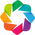

In [3]:
from __future__ import annotations

import os

import pandas as pd

import iqplot

import bokeh
from bokeh.io import show, export_svg, export_png
from bokeh.plotting import show, figure
from bokeh.models.annotations import Title

bokeh.io.output_notebook()

import holoviews as hv
from holoviews import dim

hv.extension("bokeh")



In [4]:
from scr.utils import get_task_data_split
from scr.params.vis import PLOT_EXTS

In [5]:
class BokehSave:
    """Export Bokeh plots"""

    def __init__(
        self,
        bokeh_plot: bokeh.plotting.figure,
        path2folder: str = "results/dataset_vis",
        plot_name: str = "plot",
        plot_exts: list = PLOT_EXTS,
        plot_height: int = 400,
        plot_width: int = 600,
        axis_font_size: str = "10pt",
        title_font_size: str = "10pt",
        x_name: str = "",
        y_name: str = "",
        gridoff: bool = True,
    ) -> None:
    
        self.bokeh_plot = bokeh_plot

        self.bokeh_plot.height = plot_height
        self.bokeh_plot.width = plot_width
        self.bokeh_plot.width_policy = "fixed"
        self.bokeh_plotheight_policy = "fixed"

        # change the axis title
        if x_name != "":
            self.bokeh_plot.xaxis.axis_label = x_name
        if y_name != "":
            self.bokeh_plot.yaxis.axis_label = y_name

        # Hide the grid
        if gridoff:
            self.bokeh_plot.xgrid.grid_line_color = None
            self.bokeh_plot.ygrid.grid_line_color = None

        # The subfolder for each landscape
        self.path2folder = path2folder

        # Check if the folder exists and create one if not
        os.makedirs(self.path2folder, exist_ok=True)

        # The actual name of the plot
        self.plot_name = plot_name

        # Add title to the plot itself
        t = Title()
        t.text = self.plot_name.replace("-", " ").replace("_", " ")
        self.bokeh_plot.title = t
        # self.bokeh_plot.title.text = self.plot_name.replace("-", " ").replace("_", " ")

        # adjust title and axis
        self.bokeh_plot.title.text_font_size = title_font_size
        self.bokeh_plot.xaxis.axis_label_text_font_size = axis_font_size
        self.bokeh_plot.xaxis.major_label_text_font_size = axis_font_size
        self.bokeh_plot.yaxis.axis_label_text_font_size = axis_font_size
        self.bokeh_plot.yaxis.major_label_text_font_size = axis_font_size

        # done formatting
        show(self.bokeh_plot)

        # A list of the extensions
        self.plot_exts = plot_exts

        assert isinstance(
            self.plot_exts, (list, str)
        ), "plot_exts should be a string or a list of strings"
        # Convert to a list if it is a string
        if isinstance(self.plot_exts, str):
            self.plot_exts = [self.plot_exts]

        # Check if the extension has the period and add one if not
        self.plot_exts = ["." + ext if ext[0] != "." else ext for ext in self.plot_exts]

        assert (
            len([ext for ext in self.plot_exts if ext not in PLOT_EXTS]) == 0
        ), "More extension than supported"

        # Call the function to save the paths and return the paths
        self._plotpaths = self.get_path_export_plots()

        # Actually save plots
        self.export_plots()

    def get_path_export_plots(self):
        """Check the extension and join the parts into a path"""
        self._plotpaths = [os.path.join(self.path2folder, self.plot_name)] * len(
            self.plot_exts
        )

        for p, plotext in enumerate(self.plot_exts):

            # Create full plot path
            self._plotpaths[p] = self._plotpaths[p] + plotext
            # self.export_plots(plotext, self._plotpaths[p])

        return self._plotpaths

    def export_plots(
        self,
    ):
        """Export based on the plot extension"""

        for (plotext, plotpath) in zip(self.plot_exts, self._plotpaths):

            if plotext == ".svg":
                export_svg(self.bokeh_plot, filename=plotpath)
            elif plotext == ".png":
                # Need to remove the tool bar and logos
                self.bokeh_plot.toolbar.logo = None
                self.bokeh_plot.toolbar_location = None
                export_png(self.bokeh_plot, filename=plotpath)

    @property
    def plotpaths(self):
        return self._plotpaths


class Dataframe2ECDF(BokehSave):
    def __init__(
        self,
        dataset_path: str,
        path2folder: str = "results/dataset_vis",
        plot_exts: list = PLOT_EXTS,
        plot_height: int = 300,
        plot_width: int = 450,
        axis_font_size: str = "10pt",
        title_font_size: str = "10pt",
        x_name: str = "fitness",
        y_name: str = "ecdf",
        gridoff: bool = True,
    ) -> None:

        df = read_std_csv(dataset_path)

        assert "target" in df.columns, f"target is not a column in {dataset_path}"

        df.loc[df["validation"] == True, "set"] = "val"

        self.bokeh_plot = iqplot.ecdf(
                df,
                q="target",
                cats="set",
                style="staircase",
                order=["train", "val", "test"],
                legend_location="bottom_right",
                line_kwargs={"line_width": 2.5},
            )
        
        super(Dataframe2ECDF, self).__init__(
            bokeh_plot=self.bokeh_plot,
            path2folder=path2folder,
            plot_name="-".join(get_task_data_split(dataset_path)),
            plot_exts=plot_exts,
            plot_height=plot_height,
            plot_width=plot_width,
            axis_font_size=axis_font_size,
            title_font_size=title_font_size,
            x_name=x_name,
            y_name=y_name,
            gridoff=gridoff,
        )

In [31]:
Dataframe2ECDF("data/proeng/gb1/low_vs_high.csv")

In [6]:
df = pd.read_csv("data/proeng/gb1/low_vs_high.csv")
df
df.loc[df["validation"] == True, "set"] = "val"

In [67]:
from scr.vis.iqplot_striphis import striphistogram

In [68]:
show(
    striphistogram(
        df,
        q="target",
        cats=["set"],
        spread="jitter",
        # jitter=True,
        color_column="set",
        top_level="histogram",
        marker_kwargs=dict(alpha=0.1),
        spread_kwargs={'distribution': 'normal', 'width': 0.1},
        q_axis="y",
        
    )
)

In [66]:
df["target"][df["sequence"] == df.iloc[0].sequence].values[0]

1.0

In [57]:
df.head()

,sequence,target,set,validation,__label
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.000000,test,NaN,test
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.445905,test,NaN,test
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.690164,test,NaN,test
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.170550,test,NaN,test
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.401243,test,NaN,test


In [70]:
show(
    stripbox(
        df,
        q="target",
        cats=["set"],
        spread="jitter",
        # jitter=True,
        color_column="set",
        top_level="box",
        marker_kwargs=dict(alpha=0.1),
        # spread_kwargs={'distribution': 'normal', 'width': 0.1},
        q_axis="y",
        
    )
)

In [24]:
test = hv.render(
            hv.Violin(df, kdims="set", vdims="target",).opts(
                # height=self._plot_height,
                # width=self._plot_width,
                # violin_fill_color=self._violin_fill_color,
                # cmap=self._cmap,
            )
        )